<a href="https://colab.research.google.com/github/skmanamperi/IPR/blob/main/cat_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [3]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf

import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: skmana
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:00<00:00, 1.01GB/s]


In [7]:
BATCH_SIZE =32
IMAGE_SIZE = (128,128)  #shape pixels

In [8]:
train_dir = "/content/cats-and-dogs-for-classification/cats_dogs/train"
test_dir = "/content/cats-and-dogs-for-classification/cats_dogs/test"

In [9]:
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE, subset = 'training', validation_split = 0.1, seed =42)
validation_data = tf.keras.utils.image_dataset_from_directory(train_dir, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE, subset = 'validation', validation_split = 0.1, seed =42)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size = BATCH_SIZE, image_size = IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [10]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [11]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)  #3 - RGB
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


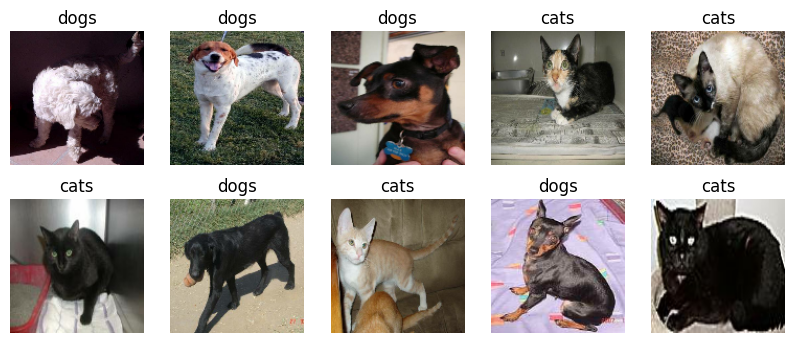

In [14]:
#plot sample
plt.figure(figsize = (10,4))
for image, label in train_data.take(1):
  for i in range (10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('Off')

In [15]:
#feature scaling
for image, label in train_data.take(1):
  for i in range(1):
    print(image)


tf.Tensor(
[[[[ 85.07135    95.16901   118.6026   ]
   [ 73.450806   51.834015   96.53674  ]
   [ 77.49155    41.6745     96.203766 ]
   ...
   [141.32031   101.359375   84.67969  ]
   [139.01562   101.97656    85.97656  ]
   [136.        103.         86.       ]]

  [[ 91.555084  108.553894  115.95703  ]
   [ 86.658966   74.99762   104.00662  ]
   [ 74.58209    42.252106   91.69345  ]
   ...
   [140.66797   103.02734    85.34766  ]
   [141.31522   105.62143    88.58389  ]
   [139.30469   106.30469    88.609375 ]]

  [[ 94.50064   113.828766  114.16342  ]
   [ 93.45697    98.646454  109.95505  ]
   [ 79.53265    62.58133    97.458435 ]
   ...
   [140.50781   104.         85.75391  ]
   [138.49615   106.47272    85.48834  ]
   [139.        107.         85.50781  ]]

  ...

  [[207.2461    194.2461    188.2461   ]
   [207.7539    195.7539    183.73828  ]
   [206.67508   194.67508   180.67508  ]
   ...
   [206.48898   199.48898   191.48898  ]
   [206.29501   201.27939   195.27554  ]
   [2

In [16]:
#normalization
train_data = train_data.map(lambda x,y: (x/255,y))
validation_data = validation_data.map(lambda x,y: (x/255,y))
test_data = test_data.map(lambda x,y: (x/255,y))

In [17]:
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.26377553 0.21301365 0.11813726]
   [0.5353891  0.38347432 0.20359987]
   [0.5515419  0.38676974 0.19257022]
   ...
   [0.67971814 0.58952206 0.3934436 ]
   [0.6745098  0.58431375 0.3882353 ]
   [0.66332316 0.57312703 0.37704864]]

  [[0.23344655 0.18925542 0.15019915]
   [0.48180148 0.34551165 0.20767464]
   [0.5208326  0.37555075 0.18625896]
   ...
   [0.6862745  0.59607846 0.4       ]
   [0.67977345 0.5895774  0.39349893]
   [0.6684283  0.5782322  0.3821538 ]]

  [[0.22841606 0.19784008 0.19708419]
   [0.3618566  0.26410797 0.1702663 ]
   [0.44014892 0.315451   0.15907294]
   ...
   [0.6901961  0.6        0.40392157]
   [0.68235296 0.5921569  0.39607844]
   [0.66525733 0.57506126 0.37898284]]

  ...

  [[0.7563417  0.70143974 0.5092828 ]
   [0.7183206  0.66341865 0.47126177]
   [0.73020285 0.6753009  0.48314402]
   ...
   [0.4885723  0.440625   0.2917794 ]
   [0.52421874 0.47069523 0.32435638]
   [0.5433364  0.492356   0.3220641 ]]

  [[0.7295343  0.6746324  0.482530

In [18]:
#data augmentation layer
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
     tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
#model architecture
model = tf.keras.models.Sequential()
model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size =3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size =3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size =3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten()) #multi to 1D array

model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) #binary




In [25]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,325,825 (12.69 MB)

 Trainable params: 3,325,569 (12.69 MB)

 Non-trainable params: 256 (1.00 KB)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [28]:
start_time = time.time()
history = model.fit(train_data, epochs = 20, validation_data = validation_data)
end_time = time.time()


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.5561 - loss: 0.7063 - val_accuracy: 0.6413 - val_loss: 0.6487
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6119 - loss: 0.6498 - val_accuracy: 0.6313 - val_loss: 0.6307
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6426 - loss: 0.6221 - val_accuracy: 0.5750 - val_loss: 0.6417
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6936 - loss: 0.5875 - val_accuracy: 0.5512 - val_loss: 0.8240
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6887 - loss: 0.5849 - val_accuracy: 0.6150 - val_loss: 0.7591
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7143 - loss: 0.5578 - val_accuracy: 0.5925 - val_loss: 0.6996
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7185 - loss: 0.5495 - val_accuracy: 0.7500 - val_loss: 0.5121
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7211 - loss: 0.5412 - val_ac

In [29]:
history.history

{'accuracy': [0.582361102104187,
  0.6272222399711609,
  0.652916669845581,
  0.6940277814865112,
  0.6994444727897644,
  0.7111111283302307,
  0.7183333039283752,
  0.7306944727897644,
  0.7423611283302307,
  0.7581944465637207,
  0.7630555629730225,
  0.7530555725097656,
  0.7712500095367432,
  0.7794444561004639,
  0.7786111235618591,
  0.7915277481079102,
  0.7891666889190674,
  0.8026388883590698,
  0.8031944632530212,
  0.8061110973358154],
 'loss': [0.678071141242981,
  0.6389424204826355,
  0.6135731339454651,
  0.5836424827575684,
  0.5783025622367859,
  0.5603005886077881,
  0.5467649698257446,
  0.5330895185470581,
  0.517244815826416,
  0.4924539625644684,
  0.4859156608581543,
  0.49306556582450867,
  0.4764871895313263,
  0.4593091905117035,
  0.4660622477531433,
  0.4452386498451233,
  0.4445395767688751,
  0.4292125105857849,
  0.4240871071815491,
  0.41422438621520996],
 'val_accuracy': [0.6412500143051147,
  0.6312500238418579,
  0.574999988079071,
  0.551249980926513

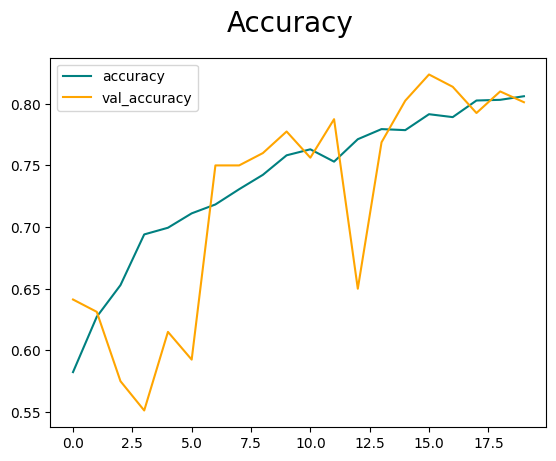

In [32]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color ='teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color ='orange',label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend()
plt.show()

In [33]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

In [36]:
for batch in test_data.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  precision.update_state(y,yhat)
  recall.update_state(y,yhat)
  accuracy.update_state(y,yhat)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

In [38]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7351263165473938>

In [39]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7885000109672546>

In [40]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9020000100135803>

In [41]:
!pip install opencv-python  #read image

In [42]:
import cv2

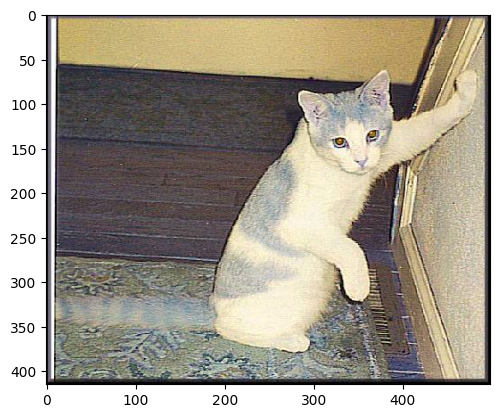

In [54]:
image = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/test/cats/cat.4001.jpg")
plt.imshow(image)
plt.show()

In [68]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255
scaled_image

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.24648719, 0.31810176, 0.3585123 ],
        [0.08592637, 0.11106843, 0.15576608],
        [0.0356279 , 0.04982503, 0.09611954],
        ...,
        [0.6072441 , 0.58763623, 0.58371466],
        [0.6044424 , 0.57817096, 0.5764706 ],
        [0.5770374 , 0.54566485, 0.54566485]],

       [[0.4303086 , 0.49249113, 0.50228876],
        [0.12266331, 0.1451817 , 0.17475292],
        [0.08608428, 0.0847822 , 0.1374678 ],
        ...,
        [0.6205931 , 0.6009852 , 0.59706366],
        [0.61457705, 0.5883056 , 0.58660525],
        [0.582692  , 0.5513195 , 0.5513195 ]],

       [[0.39226255, 0.5224709 , 0.6079746 ],
        [0.18462105, 0.29083478, 0.3956908 ],
        [0.28411457, 0.36942402, 0.5046488 ],
        ...,
        [0.62244177, 0.6028339 , 0.59891236],
        [0.61009014, 0.5838187 , 0.58211833],
        [0.59411603, 0.5627435 , 0.5627435 ]],

       ...,

       [[0.4023663 , 0.4768761 , 0.6062879 ],
        [0.39

In [69]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [70]:
y_hat = model.predict(np.expand_dims(scaled_image,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [71]:
y_hat

array([[0.9031705]], dtype=float32)

In [61]:
if y_hat>=0.5:
  print(class_names[0])
else:
  print(class_names[1])

cats


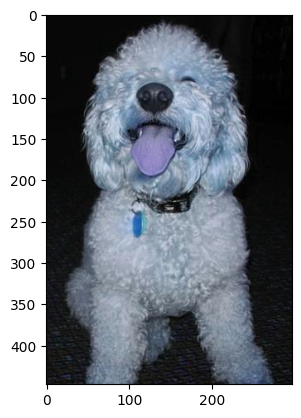

In [78]:
pic = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4003.jpg")
plt.imshow(pic)
plt.show()

In [79]:
resized_image = tf.image.resize(pic, IMAGE_SIZE)
scaled_image = resized_image/255
y_hat = model.predict(np.expand_dims(scaled_image,0))
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.95250106]], dtype=float32)

In [80]:
if y_hat>=0.5:
  print(class_names[0])
else:
  print(class_names[1])

cats


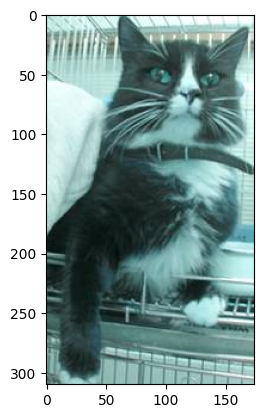

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[0.9052296]], dtype=float32)

In [81]:
pic = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/test/cats/cat.4007.jpg")
plt.imshow(pic)
plt.show()
resized_image = tf.image.resize(pic, IMAGE_SIZE)
scaled_image = resized_image/255
y_hat = model.predict(np.expand_dims(scaled_image,0))
y_hat


In [82]:
if y_hat>=0.5:
  print(class_names[0])
else:
  print(class_names[1])

cats


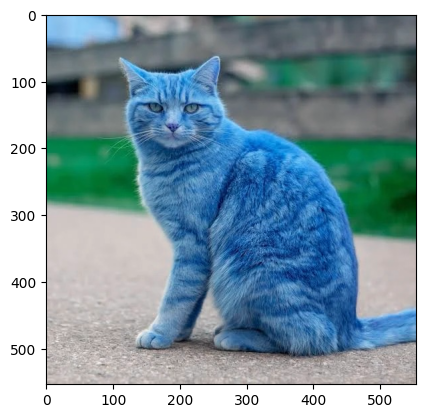

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[0.80502355]], dtype=float32)

In [83]:
pic = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/WhatsApp Image 2025-11-20 at 00.25.59.jpeg")
plt.imshow(pic)
plt.show()
resized_image = tf.image.resize(pic, IMAGE_SIZE)
scaled_image = resized_image/255
y_hat = model.predict(np.expand_dims(scaled_image,0))
y_hat


In [84]:
if y_hat>=0.5:
  print(class_names[0])
else:
  print(class_names[1])

cats


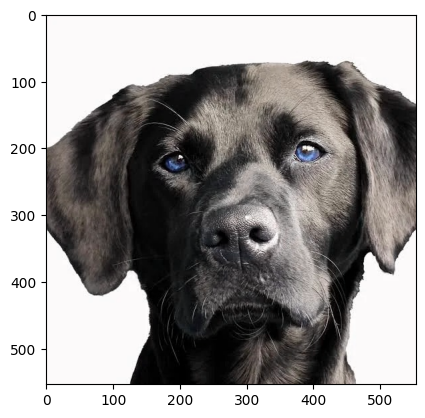

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[0.93453866]]
cats


In [92]:
pic = cv2.imread("/content/cats-and-dogs-for-classification/cats_dogs/WhatsApp Image 2025-11-20 at 00.40.13.jpeg")
plt.imshow(pic)
plt.show()
resized_image = tf.image.resize(pic, IMAGE_SIZE)
scaled_image = resized_image/255
y_hat = model.predict(np.expand_dims(scaled_image,0))
print(y_hat)
if y_hat>=0.5:
  print(class_names[0])
elif y_hat<0.5:
  print(class_names[1])
else:
  print("NA")